# Self-organising Map

In [ ]:
# install existing implementation of SOM

!pip install minisom

In [6]:
# imports

from minisom import MiniSom
from keras.datasets import mnist
import numpy as np
from tqdm import tqdm
from skimage.metrics import mean_squared_error, structural_similarity, peak_signal_noise_ratio
import matplotlib.pyplot as plt
import mplcyberpunk

plt.style.use("cyberpunk")
import gc

seed = 42
np.random.seed(seed)

In [2]:
# setting font size for graphs

SIZE = 14

plt.rc('font', size=SIZE)         
plt.rc('axes', titlesize=SIZE)  
plt.rc('axes', labelsize=SIZE)  
plt.rc('xtick', labelsize=SIZE)    
plt.rc('ytick', labelsize=SIZE)  
plt.rc('legend', fontsize=SIZE) 
plt.rc('figure', titlesize=SIZE)

# set color cycle

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab10.colors)

In [3]:
# load mnist data

(X_train, y_train), (X_test, y_test) = mnist.load_data()

train_data = {i:None for i in range(10)}

for i in range(10):
    xi = X_test[y_test==i]
    train_data[i] = xi

In [7]:
# define custom function for corruption 
# since hopfield one works with different data range

def get_corrupted_input(input, corruption_level):
    """Get image with noise added
    
    :param input: image array to be corrupted
    :type input: np.ndarray
    :param corruption_level: corruption level, range [0.0-1.0]
    :type corruption_level: np.float
    :return: corrupted image
    :rtype: np.ndarray
    """
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = np.random.rand(1)[0]
    return corrupted

## Demo

In [35]:
# get some digits & preprocess

demo_train = []
digits = np.random.randint(0, 10, size=3)

for i in digits:
    demo_train.append(X_train[y_train==i][0].flatten())

demo_train = [i/255.0 for i in demo_train]
demo_train = np.array(demo_train)

In [37]:
# train som

som = MiniSom(28, 28, 784, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
som.random_weights_init(demo_train)
som.train(demo_train, 1000, random_order=True, verbose=True)

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 8.658260884859883e-33


C:\Users\arpit\AppData\Roaming\Python\Python39\site-packages\minisom.py:536: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


In [42]:
# test with 20% corruption & get preds

demo_test = [get_corrupted_input(x, 0.2) for x in demo_train]
preds = som.quantization(demo_test)

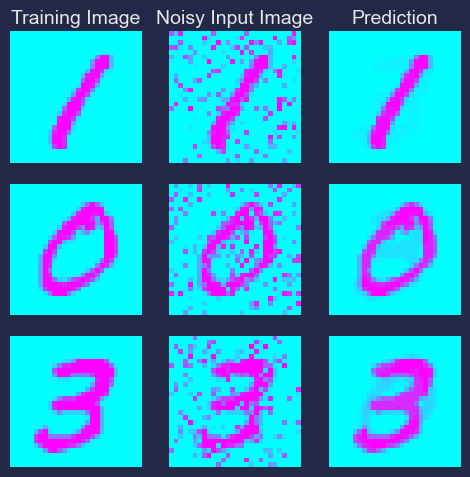

In [43]:
# plot demo samples

utils.plot(demo_train, demo_test, preds)

In [76]:
gc.collect()

0

## Evaluation

In [8]:
# define metric dicts and corruption levels (10 to 50%)

mse = {i:[] for i in range(10)}
psnr = {i:[] for i in range(10)}
ssim = {i:[] for i in range(10)}

corruption_levels = [0.1, 0.2, 0.3, 0.4, 0.5]

In [9]:
# train network and evaluate metrics for digits

for i in tqdm(range(10)):

    train = train_data[i]
    # preprocess data
    train_processed = [x.flatten() for x in train]
    train_processed = [x/255.0 for x in train_processed]
    train_processed = np.array(train_processed)

    # instantiate model & train
    som = MiniSom(28, 28, 784, sigma=4,
              learning_rate=0.5, neighborhood_function='triangle')
    som.random_weights_init(train_processed)
    som.train(train_processed, 1000, random_order=True, verbose=True)

    # pattern recovery for varying corruption levels
    for corruption in corruption_levels:
        test = [get_corrupted_input(x, corruption) for x in train_processed]
        preds = som.quantization(test)
        total_mse = 0
        total_psnr = 0
        total_ssim = 0
        for j in range(len(train)):
            total_mse += mean_squared_error(train_processed[j], preds[j])
            total_psnr += peak_signal_noise_ratio(train_processed[j], preds[j].astype('int32'), data_range=255)
            total_ssim += structural_similarity(train_processed[j], preds[j].astype('int32'), data_range=255)
        mse[i].append(total_mse/len(test))
        psnr[i].append(total_psnr/len(test))
        ssim[i].append(total_ssim/len(test))
        

  0%|          | 0/10 [00:00<?, ?it/s]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.534053810798177


 10%|█         | 1/10 [00:10<01:31, 10.16s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.7227788944632925


 20%|██        | 2/10 [00:21<01:27, 10.95s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.057038875963336


 30%|███       | 3/10 [00:32<01:16, 11.00s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.8062536002145575


 40%|████      | 4/10 [00:42<01:03, 10.60s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.4377602135153076


 50%|█████     | 5/10 [00:52<00:51, 10.31s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.743722090452966


 60%|██████    | 6/10 [01:02<00:40, 10.06s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.4287662993825365


 70%|███████   | 7/10 [01:11<00:29,  9.95s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.14402737613118


 80%|████████  | 8/10 [01:21<00:19,  9.90s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 4.007552402942549


 90%|█████████ | 9/10 [01:31<00:09,  9.85s/it]

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 3.2422855971794027


100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


In [10]:
gc.collect()

63

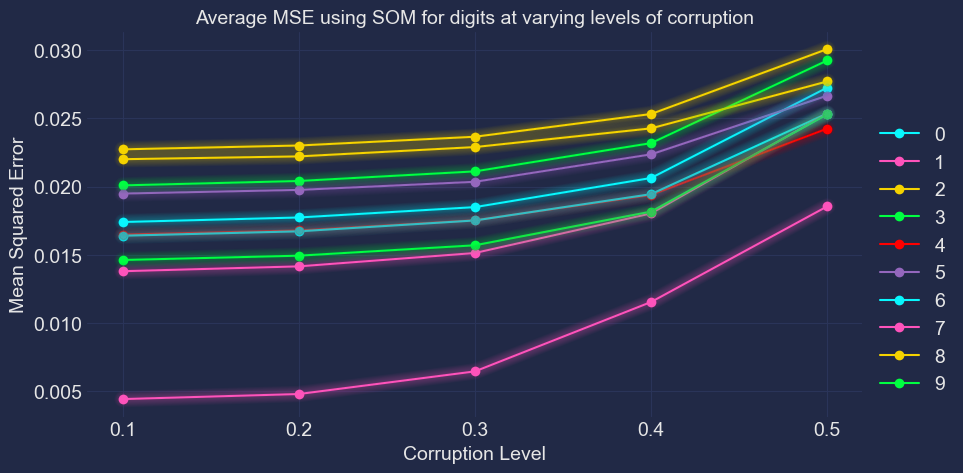

In [11]:
# plot mse

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, mse[i], label=i, marker='o')

plt.xticks(np.linspace(0.1, 0.5, 5))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Mean Squared Error")
plt.title("Average MSE using SOM for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

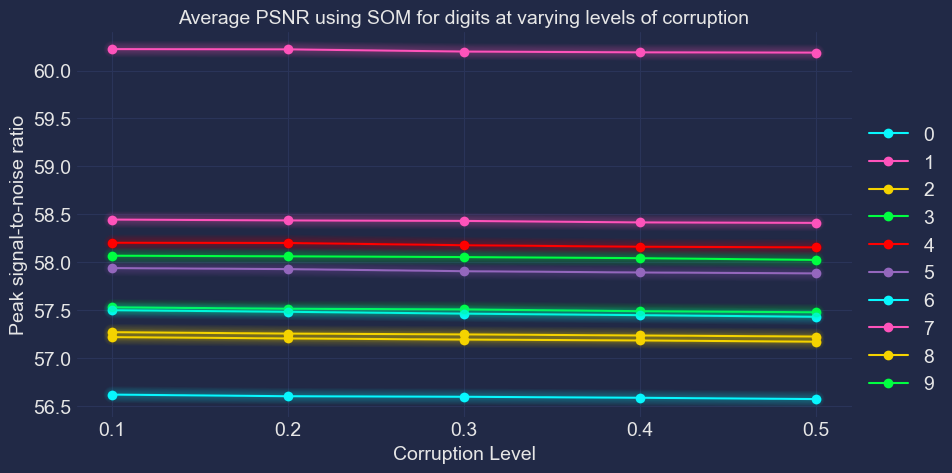

In [12]:
# plot psnr

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, psnr[i], label=i, marker='o')

plt.xticks(np.linspace(0.1, 0.5, 5))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Peak signal-to-noise ratio")
plt.title("Average PSNR using SOM for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

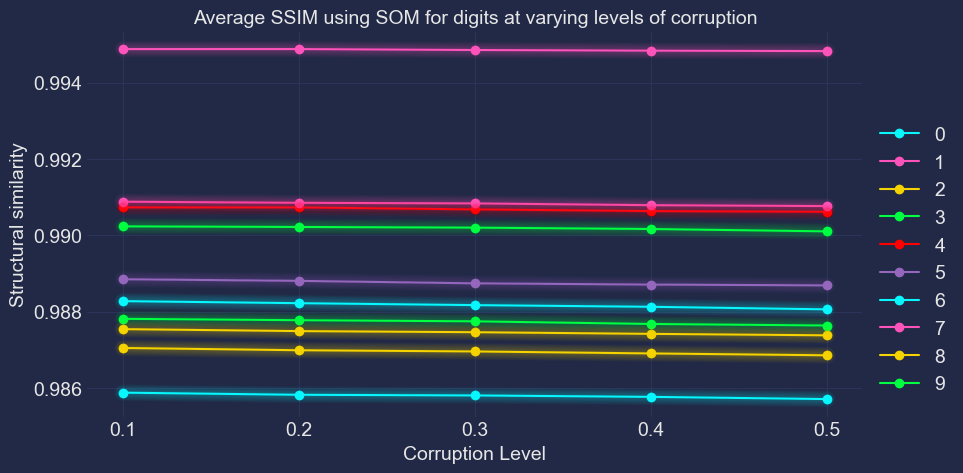

In [13]:
# plot ssim

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.plot(corruption_levels, ssim[i], label=i, marker='o')

plt.xticks(np.linspace(0.1, 0.5, 5))
plt.legend(bbox_to_anchor=(1,0.8))
plt.xlabel("Corruption Level")
plt.ylabel("Structural similarity")
plt.title("Average SSIM using SOM for digits at varying levels of corruption")
mplcyberpunk.make_lines_glow()
plt.show()

In [14]:
gc.collect()

19344